In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Definition of problem (as per given problem statement with additional views)
> Loantap is a platform which gives out different types of loans. They want a model to understand the creditworthiness of a given prospect for personal loans. This can be understood by past and existing customers history and from information about them.

> We are now to understand the underlying factors that could be an indicator for a delay in payment. This model needs to be able to predict the risk considering all the data we have in hand and that in turn can be used to assess the creditworthiness of new applicants.  

In [ ]:
data = pd.read_csv('logistic_regression.csv')
dataOG = data.copy(deep=True)

## Observations on shape of data, data types of all the attributes, conversion of categorical attributes to 'category' (If required), missing value detection, statistical summary.

In [ ]:
data.shape

(396030, 27)

In [ ]:
data.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
count,396030.000000,396030.000000,396030.000000,3.960300e+05,396030.000000,396030.000000,396030.000000,3.960300e+05,395754.000000,396030.000000,358235.000000,395495.000000
mean,14113.888089,13.639400,431.849698,7.420318e+04,17.379514,11.311153,0.178191,1.584454e+04,53.791749,25.414744,1.813991,0.121648
std,8357.441341,4.472157,250.727790,6.163762e+04,18.019092,5.137649,0.530671,2.059184e+04,24.452193,11.886991,2.147930,0.356174
min,500.000000,5.320000,16.080000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000,0.000000,0.000000
25%,8000.000000,10.490000,250.330000,4.500000e+04,11.280000,8.000000,0.000000,6.025000e+03,35.800000,17.000000,0.000000,0.000000
50%,12000.000000,13.330000,375.430000,6.400000e+04,16.910000,10.000000,0.000000,1.118100e+04,54.800000,24.000000,1.000000,0.000000
75%,20000.000000,16.490000,567.300000,9.000000e+04,22.980000,14.000000,0.000000,1.962000e+04,72.900000,32.000000,3.000000,0.000000
max,40000.000000,30.990000,1533.810000,8.706582e+06,9999.000000,90.000000,86.000000,1.743266e+06,892.300000,151.000000,34.000000,8.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394274 non-null  object 
 15  

### Converting categorical data to catergory data type

**Number of categories in each categorical column**

In [ ]:
categorical_cols = data.select_dtypes(include='object').columns
for col in categorical_cols:
  print(f"No. of categories in {col}: {data[col].nunique()}")

No. of categories in term: 2
No. of categories in grade: 7
No. of categories in sub_grade: 35
No. of categories in emp_title: 173105
No. of categories in emp_length: 11
No. of categories in home_ownership: 6
No. of categories in verification_status: 3
No. of categories in issue_d: 115
No. of categories in loan_status: 2
No. of categories in purpose: 14
No. of categories in title: 48816
No. of categories in earliest_cr_line: 684
No. of categories in initial_list_status: 2
No. of categories in application_type: 3
No. of categories in address: 393700


In [ ]:
data['loan_status'].value_counts(normalize=True)

loan_status
Fully Paid     0.803871
Charged Off    0.196129
Name: proportion, dtype: float64

**We have clear data imbalance of 80-20 split.**
We have about 20% of people who have paid extra charges.

In [ ]:
data['grade'] = data['grade'].astype('category') #7 grades
data['sub_grade'] = data['sub_grade'].astype('category') #35 different subgrades
data['verification_status'] = data['verification_status'].astype('category')
data['loan_status'] = data['loan_status'].astype('category')
data['purpose'] = data['purpose'].astype('category')
data['initial_list_status'] = data['initial_list_status'].astype('category')
data['application_type'] = data['application_type'].astype('category')


In [ ]:
data['term'] = data['term'].str[:3].astype(int)

In [ ]:
data['issue_d'] = pd.to_datetime(data['issue_d'], format='mixed')
data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'], format='mixed')

In [ ]:
numericalCols = data.select_dtypes(include='number').columns

## Missing values check

In [ ]:
data.isna().any()

loan_amnt               False
term                    False
int_rate                False
installment             False
grade                   False
sub_grade               False
emp_title                True
emp_length               True
home_ownership          False
annual_inc              False
verification_status     False
issue_d                 False
loan_status             False
purpose                 False
title                    True
dti                     False
earliest_cr_line        False
open_acc                False
pub_rec                 False
revol_bal               False
revol_util               True
total_acc               False
initial_list_status     False
application_type        False
mort_acc                 True
pub_rec_bankruptcies     True
address                 False
dtype: bool

- Currently, we have columns such as title and emp_title which have 40k+ unique values. We will approach these in a later time and see how we can make use of the information in them.

## Univariate Analysis (distribution plots of all the continuous variable(s) barplots/countplots of all the categorical variables)

In [ ]:
numericalCols

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'annual_inc', 'dti',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'mort_acc', 'pub_rec_bankruptcies'],
      dtype='object')

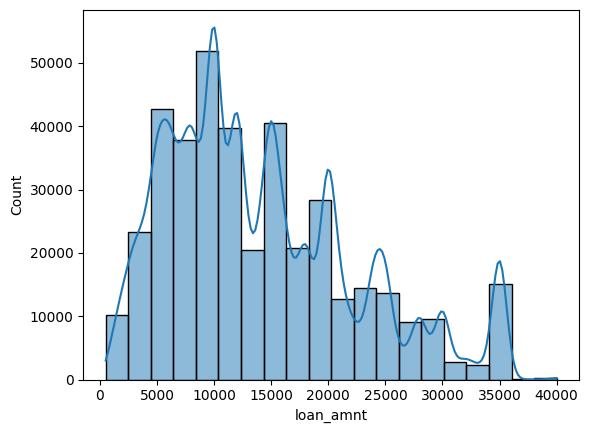

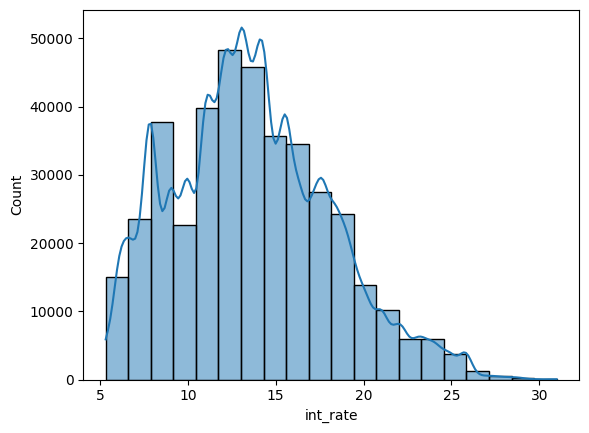

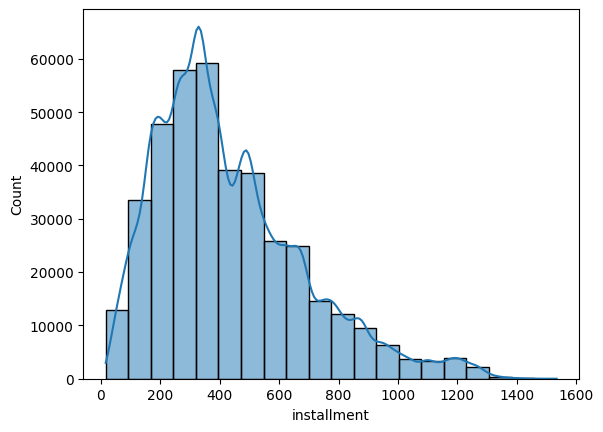

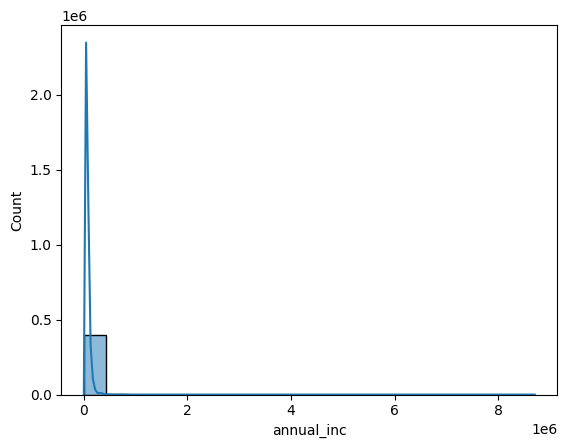

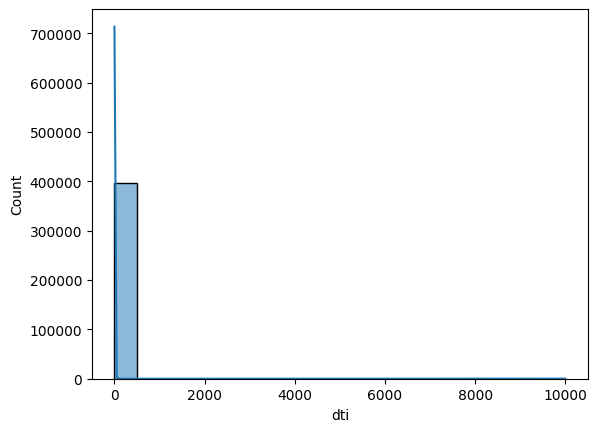

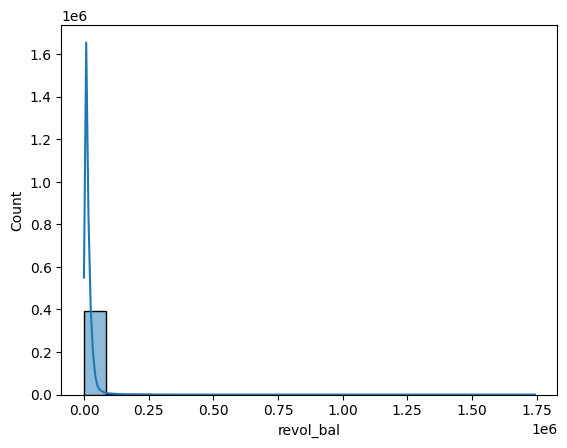

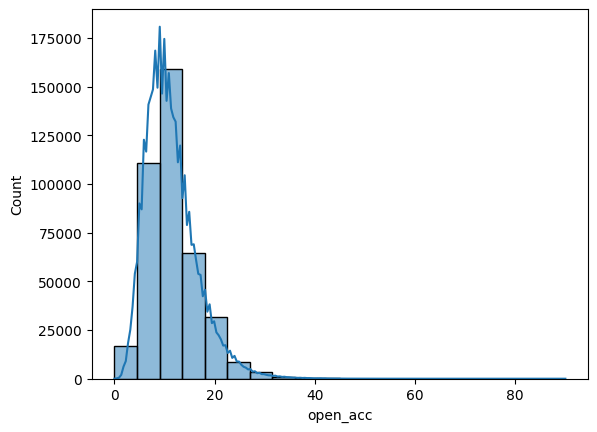

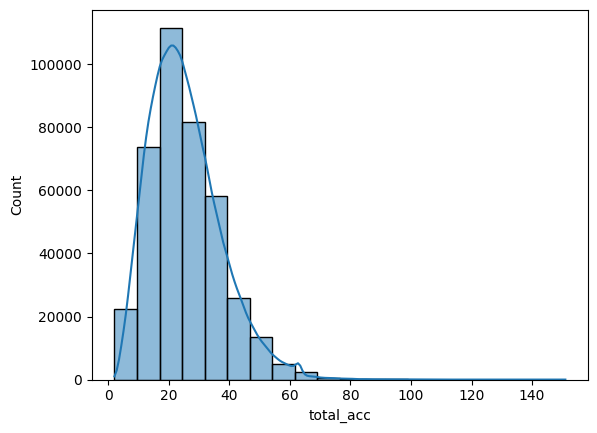

In [ ]:
for i in ['loan_amnt', 'int_rate', 'installment','annual_inc','dti','revol_bal','open_acc', 'total_acc']:
    sns.histplot(data=data, x=i, kde=True,bins=20)
    plt.show()

## Bivariate Analysis (Relationships between important variable)

**Grade vs loan_status**

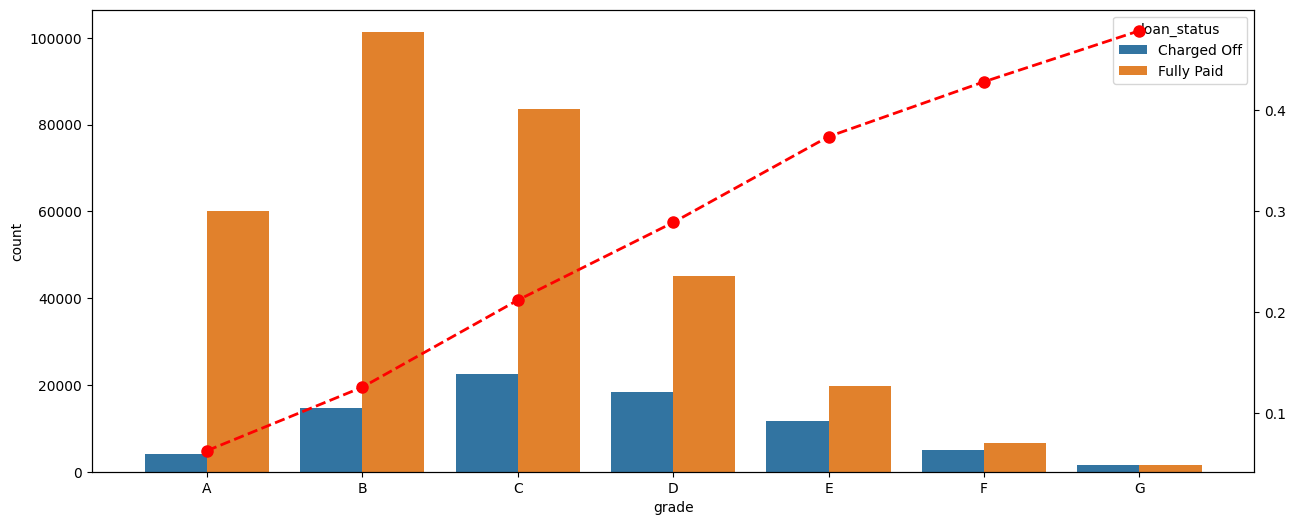

In [ ]:
plt.figure(figsize=(15, 6))
ax1 = sns.countplot(x='grade', data=data, hue='loan_status')

charged_off_ratio = data[data['loan_status'] == 'Charged Off'].groupby('grade').size() / data.groupby('grade').size()
ax2 = ax1.twinx()
ax2.plot(charged_off_ratio.index, charged_off_ratio.values, color='red', marker='o', linestyle='dashed', linewidth=2, markersize=8)

> Clearly as the grade goes down, we can see that the ratio of defaulters to non-defaulters is going up. We can see that most people are in B, C grades and the ratio is the least in A

**Subgrade vs loan_status**

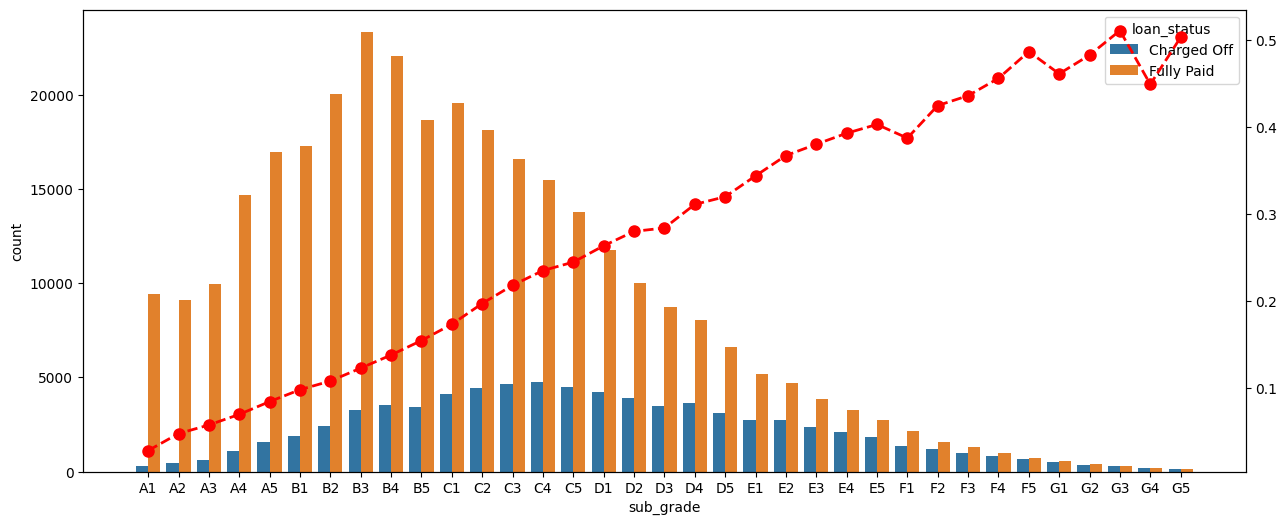

In [ ]:
plt.figure(figsize=(15, 6))
ax1 = sns.countplot(x='sub_grade', data=data, hue='loan_status')

charged_off_ratio = data[data['loan_status'] == 'Charged Off'].groupby('sub_grade').size() / data.groupby('sub_grade').size()
ax2 = ax1.twinx()
ax2.plot(charged_off_ratio.index, charged_off_ratio.values, color='red', marker='o', linestyle='dashed', linewidth=2, markersize=8)

**Home Ownership vs loan_status**

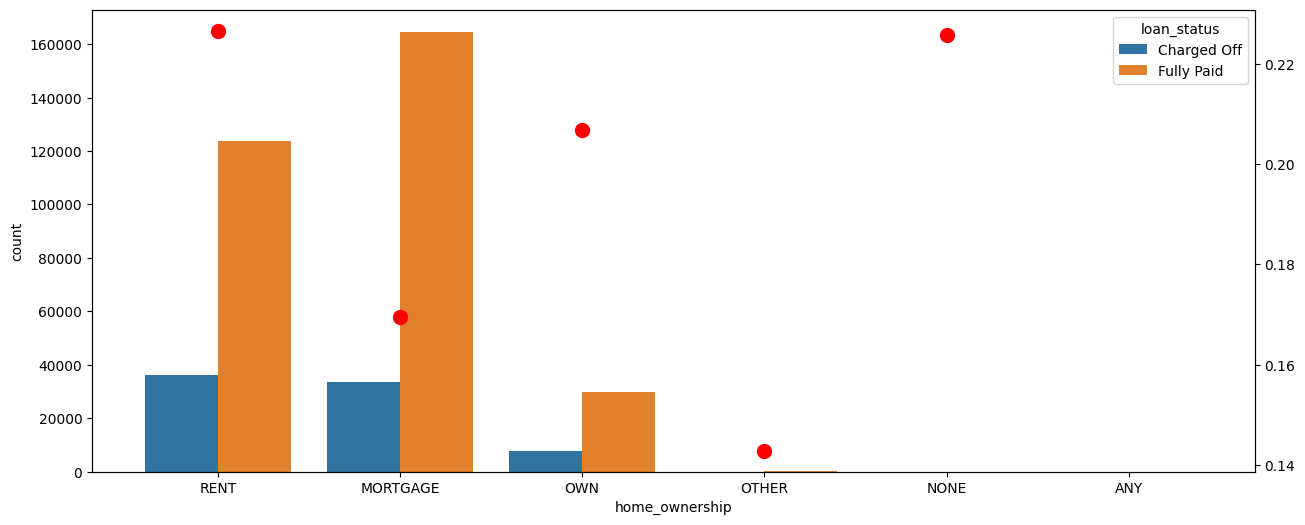

In [ ]:
plt.figure(figsize=(15, 6))
ax1 = sns.countplot(x='home_ownership', data=data, hue='loan_status')

charged_off_ratio = data[data['loan_status'] == 'Charged Off'].groupby('home_ownership').size() / data.groupby('home_ownership').size()
ax2 = ax1.twinx()
ax2.scatter(charged_off_ratio.index, charged_off_ratio.values, color='red', marker='o', s=100)

> We can see that None and Any almost have negligible amount of loan. We can shift them to OTHER category to ease our analysis

In [ ]:
data.loc[(data.home_ownership == 'ANY') | (data.home_ownership == 'NONE'), 'home_ownership'] = 'OTHER'
data.home_ownership.value_counts()

home_ownership
MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          146
Name: count, dtype: int64

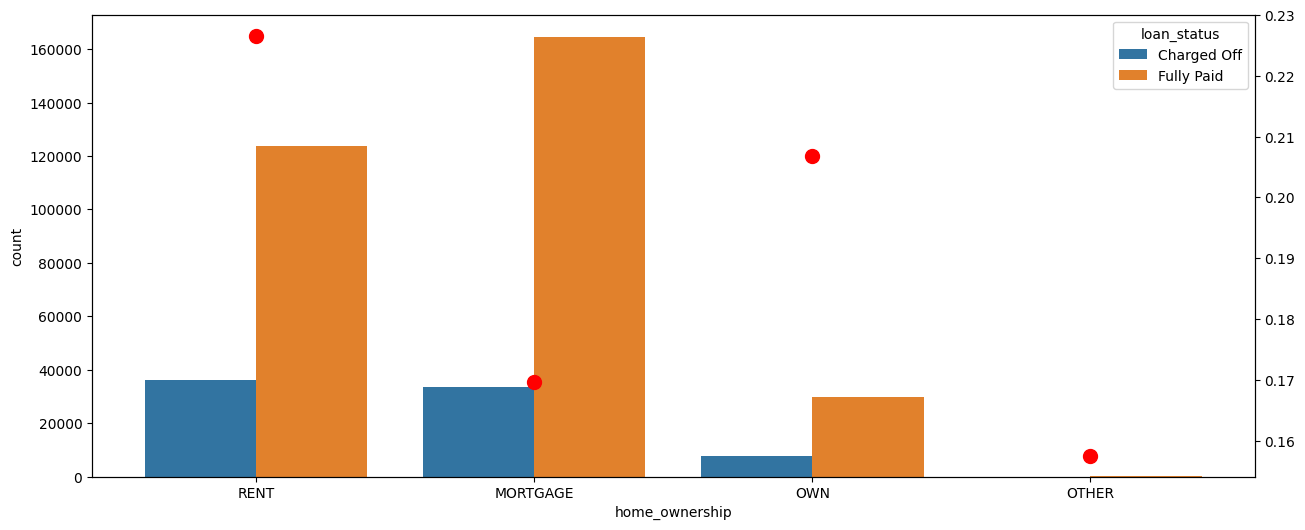

In [ ]:
plt.figure(figsize=(15, 6))
ax1 = sns.countplot(x='home_ownership', data=data, hue='loan_status')

charged_off_ratio = data[data['loan_status'] == 'Charged Off'].groupby('home_ownership').size() / data.groupby('home_ownership').size()
ax2 = ax1.twinx()
ax2.scatter(charged_off_ratio.index, charged_off_ratio.values, color='red', marker='o', s=100)

<div class="alert alert-block alert-warning">


- We can see that the Charged Off ratio is much higher in case of Rent, followed by own.

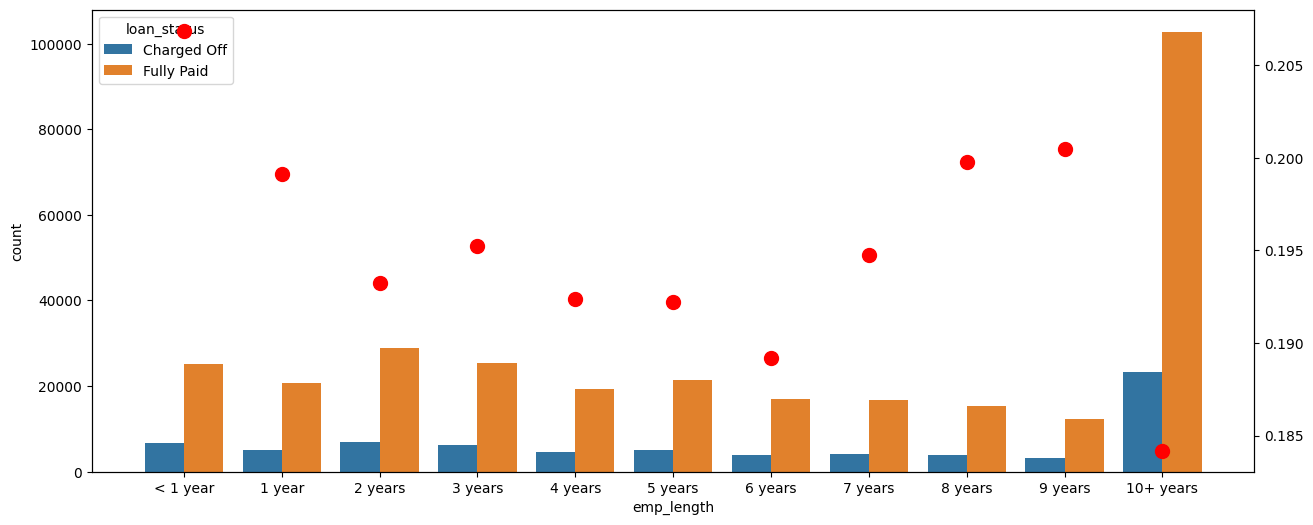

In [ ]:
plt.figure(figsize=(15, 6))
category_order = ['< 1 year','1 year','2 years','3 years','4 years','5 years','6 years','7 years','8 years','9 years','10+ years']
ax1 = sns.countplot(x='emp_length', data=data, hue='loan_status',order=category_order)

charged_off_ratio = data[data['loan_status'] == 'Charged Off'].groupby('emp_length').size() / data.groupby('emp_length').size()
ax2 = ax1.twinx()
ax2.scatter(charged_off_ratio.index, charged_off_ratio.values, color='red', marker='o', s=100)
plt.show()

<div class="alert alert-block alert-warning">

- We can see that below 1 year, 1 year, 8 year and 9 year have extremely high charged off ratio  

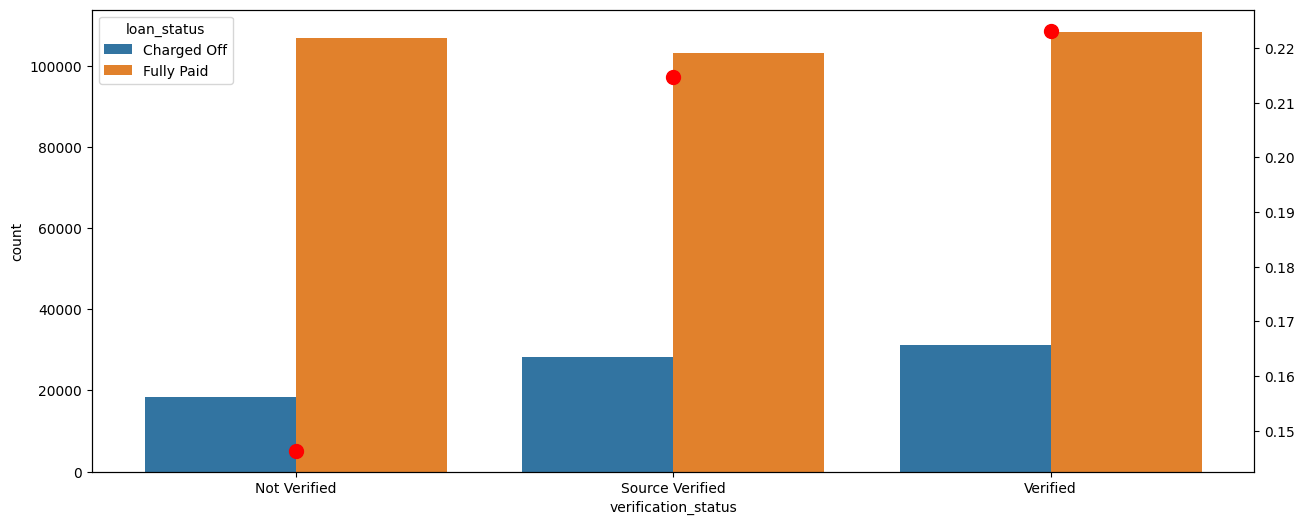

In [ ]:
plt.figure(figsize=(15, 6))
ax1 = sns.countplot(x='verification_status', data=data, hue='loan_status')

charged_off_ratio = data[data['loan_status'] == 'Charged Off'].groupby('verification_status').size() / data.groupby('verification_status').size()
ax2 = ax1.twinx()
ax2.scatter(charged_off_ratio.index, charged_off_ratio.values, color='red', marker='o', s=100)

<div class="alert alert-block alert-warning">


- Interesting! How come 'Not Verified' has a low charged off ratio whereas 'Source Verified' and 'Verified' have high charged off ratio?

In [ ]:
data.groupby(['verification_status','loan_status']).size()

verification_status  loan_status
Not Verified         Charged Off     18307
                     Fully Paid     106775
Source Verified      Charged Off     28214
                     Fully Paid     103171
Verified             Charged Off     31152
                     Fully Paid     108411
dtype: int64

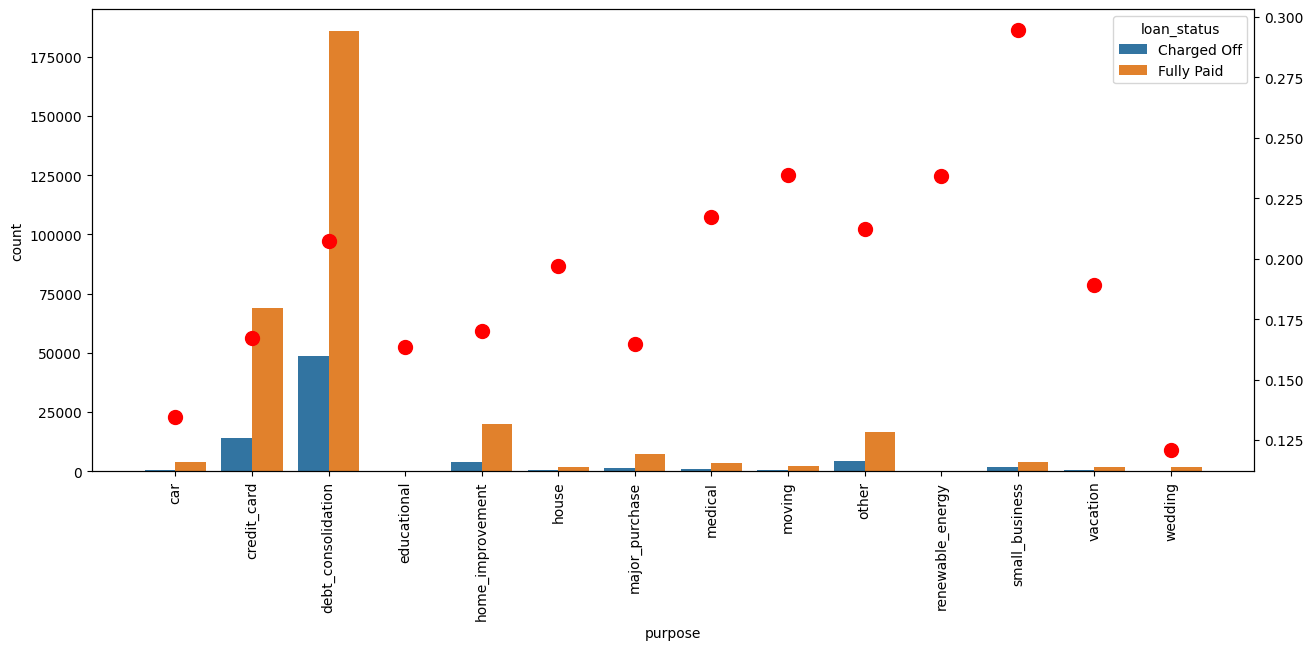

In [ ]:
plt.figure(figsize=(15, 6))
ax1 = sns.countplot(x='purpose', data=data, hue='loan_status')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
charged_off_ratio = data[data['loan_status'] == 'Charged Off'].groupby('purpose').size() / data.groupby('purpose').size()
ax2 = ax1.twinx()
ax2.scatter(charged_off_ratio.index, charged_off_ratio.values, color='red', marker='o', s=100)

<div class="alert alert-block alert-warning">

- Small business has a massive default rate
- Moving and renewable energy have the next biggest default rate
- Debt consolidation and credit seem to have the highest number of defaults as they are the most frequent purpose to take loans.

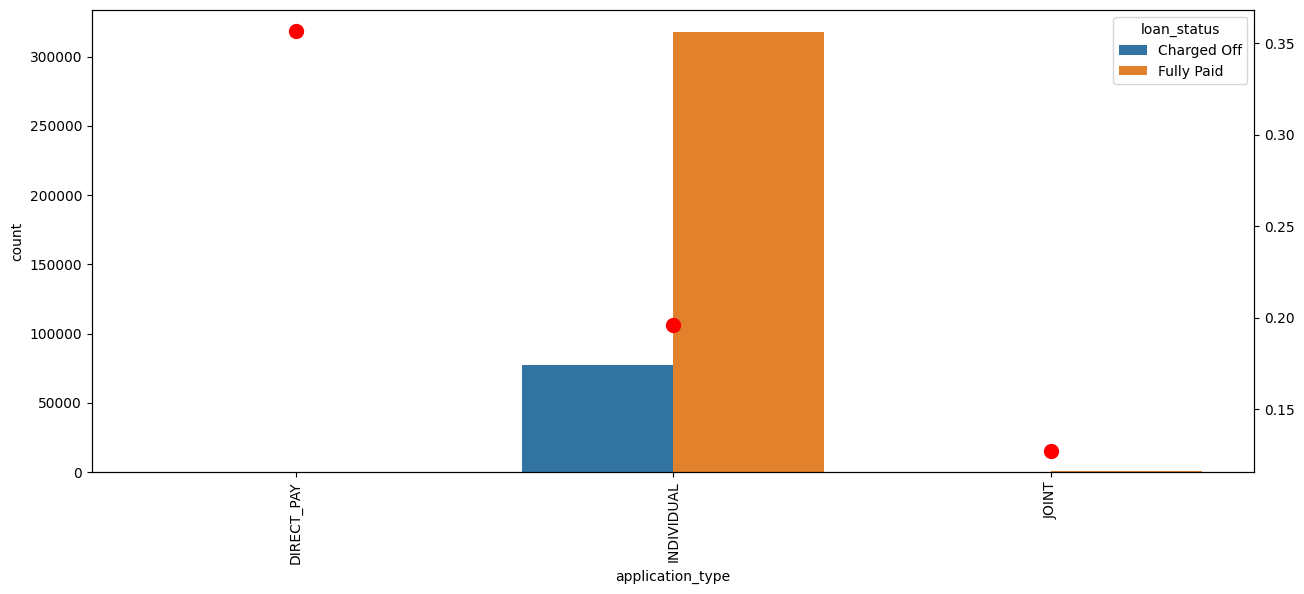

In [ ]:
plt.figure(figsize=(15, 6))
ax1 = sns.countplot(x='application_type', data=data, hue='loan_status')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
charged_off_ratio = data[data['loan_status'] == 'Charged Off'].groupby('application_type').size() / data.groupby('application_type').size()
ax2 = ax1.twinx()
ax2.scatter(charged_off_ratio.index, charged_off_ratio.values, color='red', marker='o', s=100)

<div class="alert alert-block alert-warning">

- We have very high default rate in Direct_Pay.
- Joint application reduces the risk of default.

<Axes: >

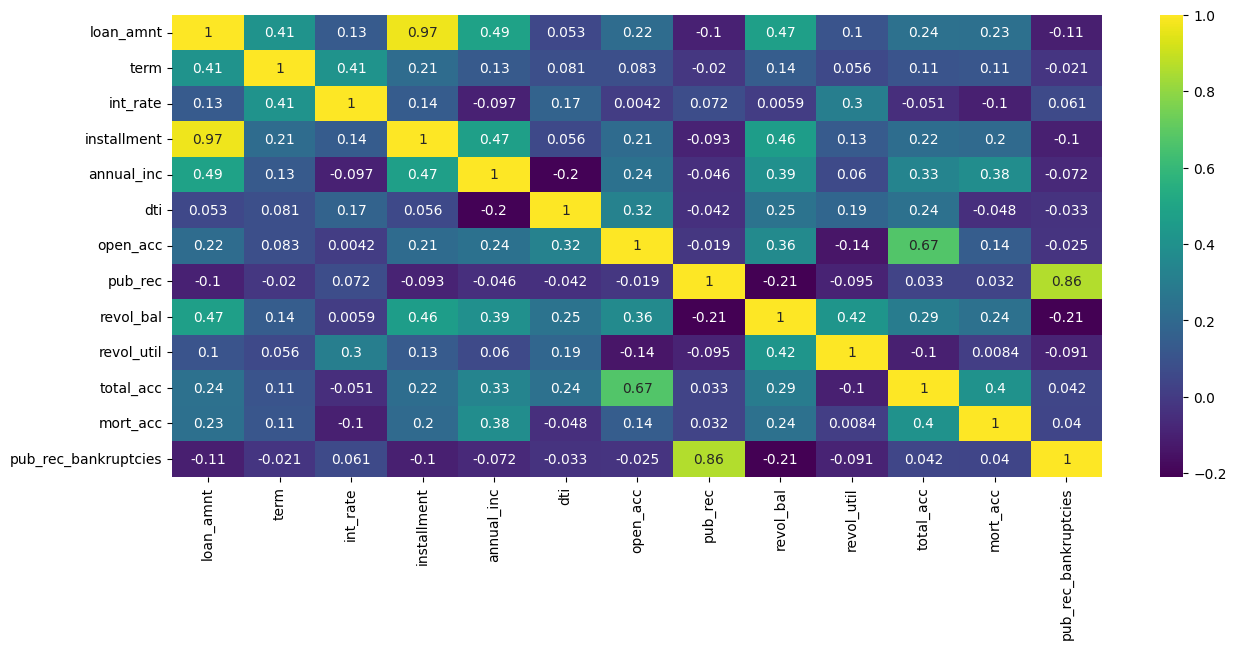

In [ ]:
plt.figure(figsize=(15, 6))
sns.heatmap(data[numericalCols].corr(method='spearman'),annot=True,cmap='viridis')

**High correlation between loan_amnt and installment. We will drop one of them.**

In [ ]:
data.drop(columns=['installment'],axis=1,inplace=True)

In [ ]:
numericalCols = numericalCols.drop('installment')

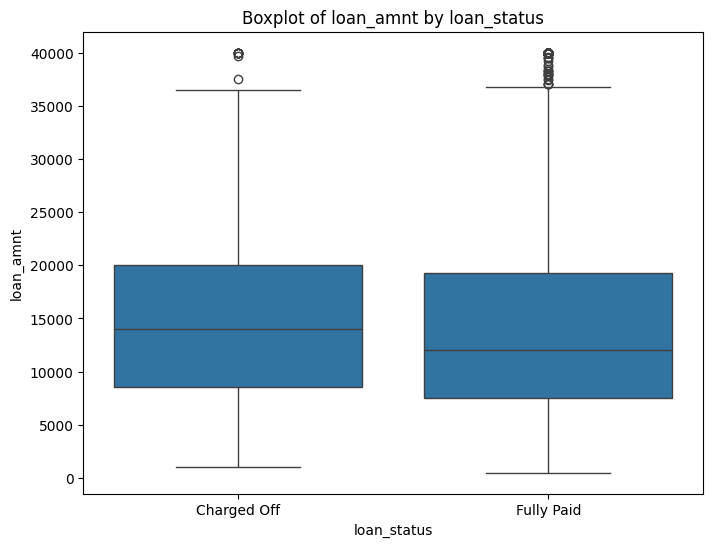

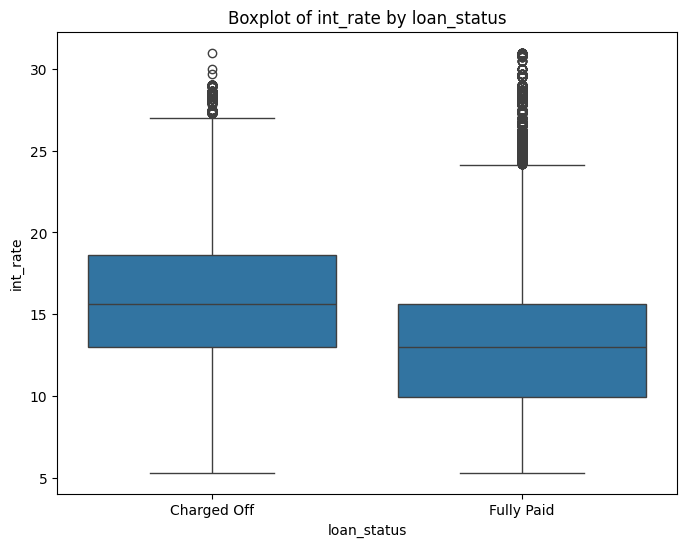

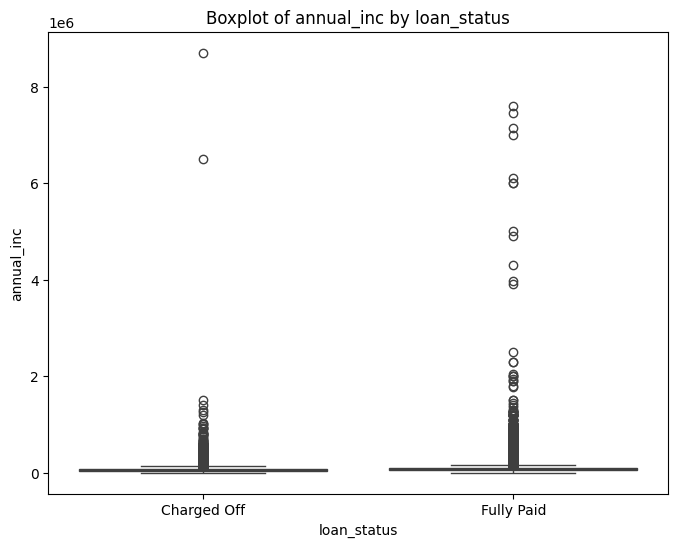

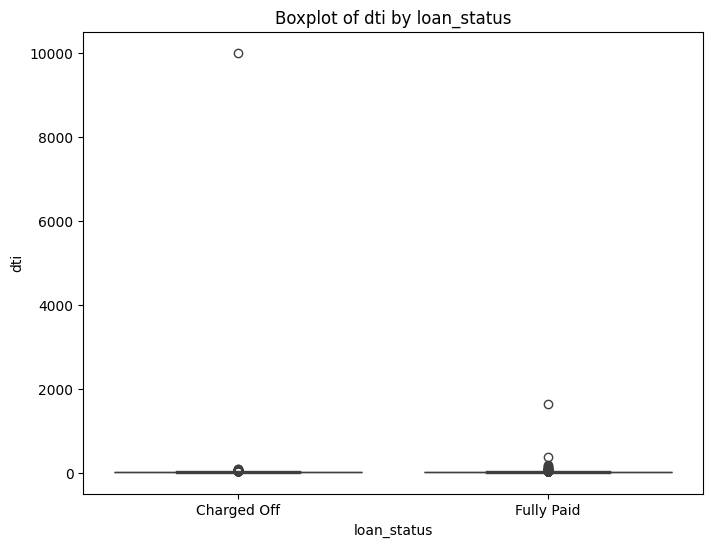

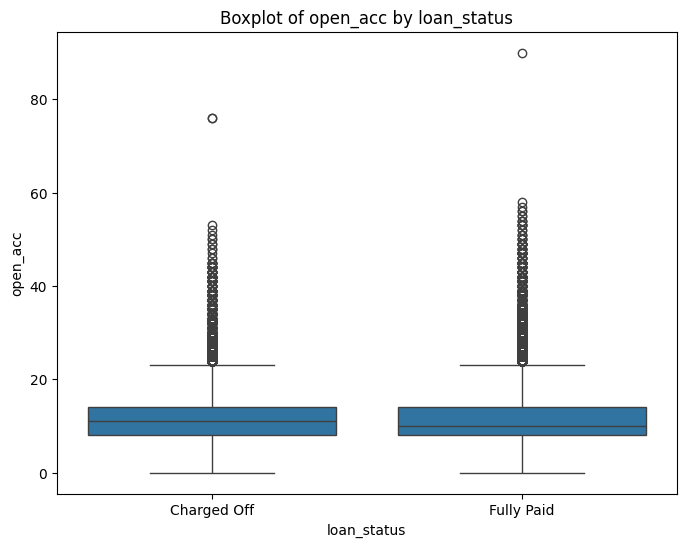

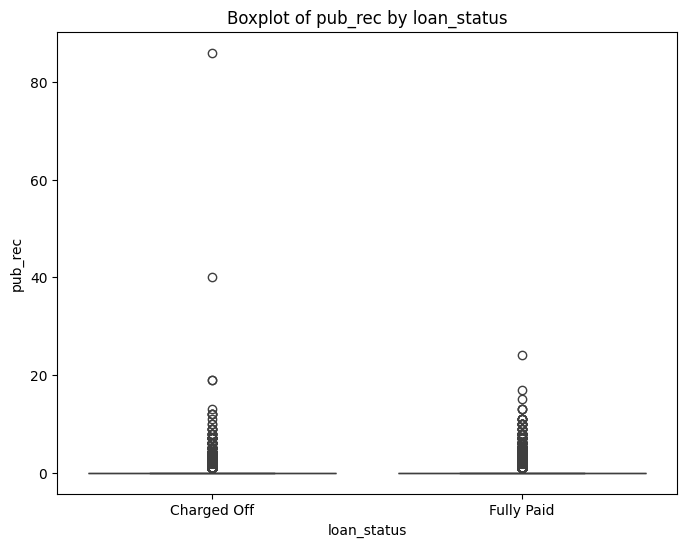

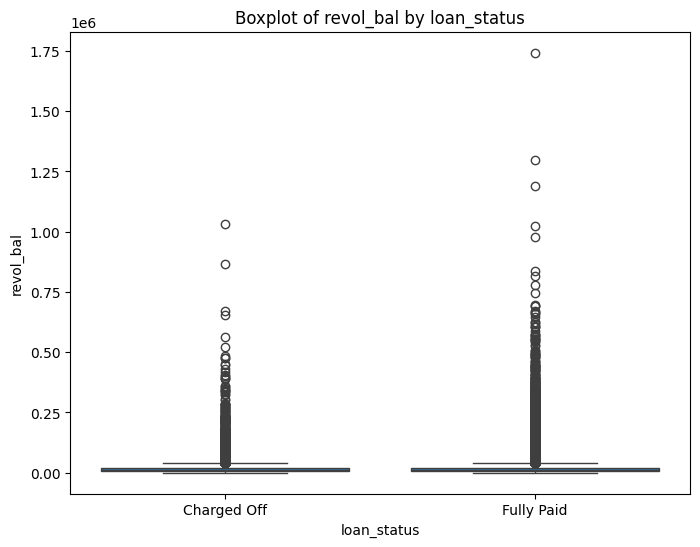

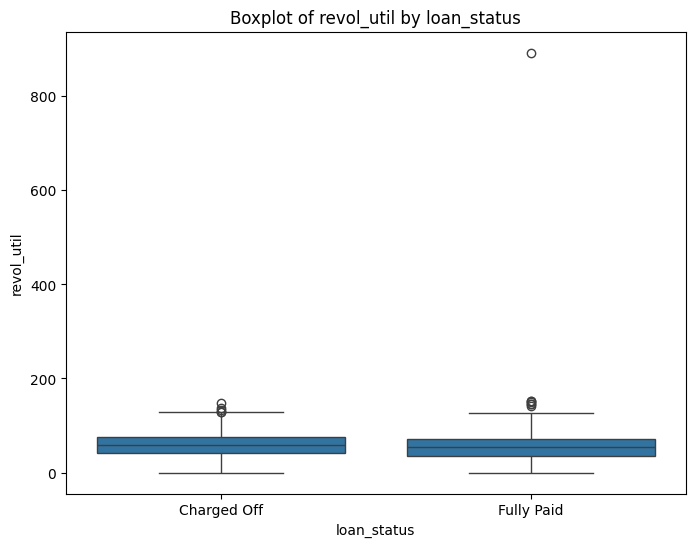

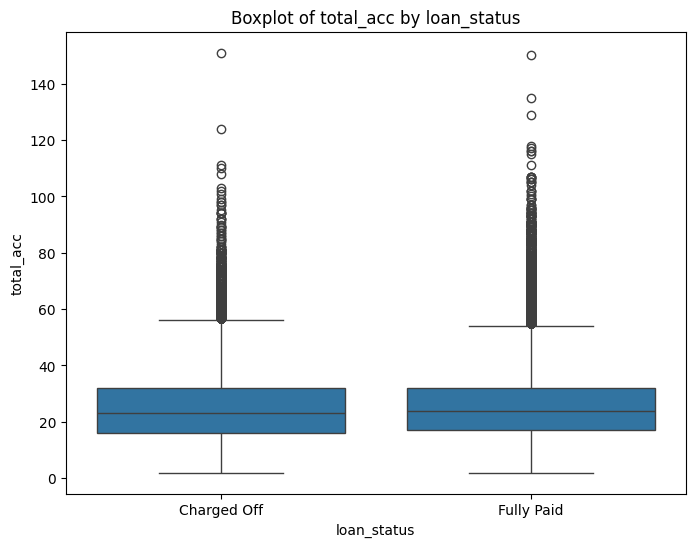

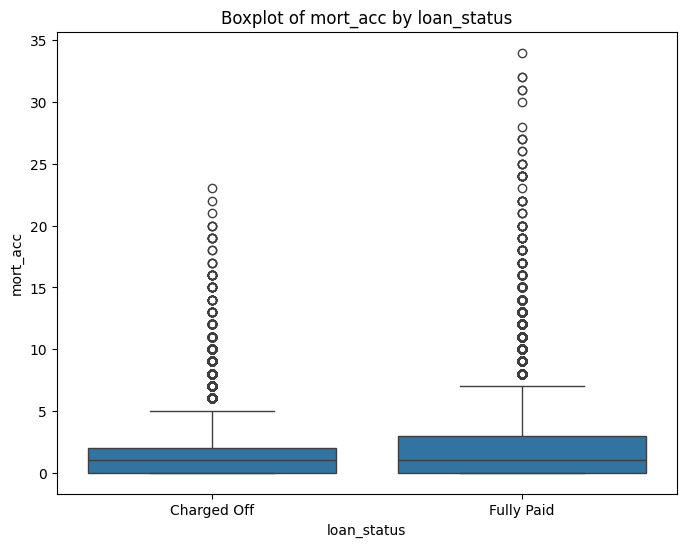

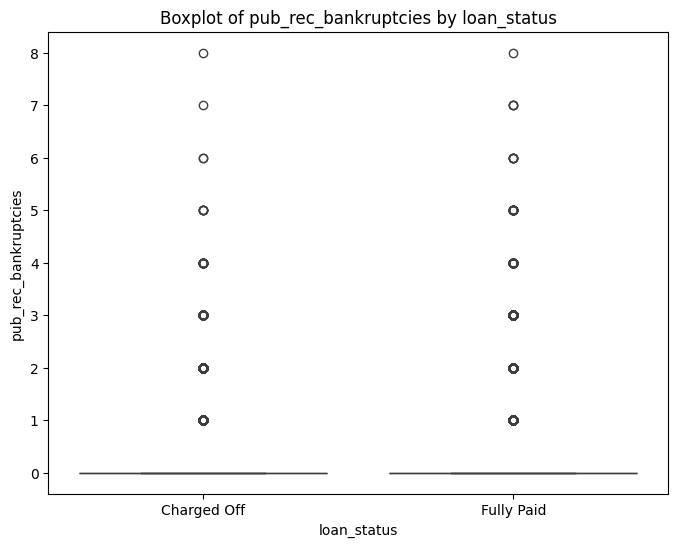

In [ ]:
for col in numericalCols.drop('term','pub_rec_bankruptcies'):
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='loan_status', y=col, data=data)
    plt.title(f'Boxplot of {col} by loan_status')
    plt.show()

<div class="alert alert-block alert-warning">

**Interesting.**
- We see that the loan amount has a slightly lower range and mean for Fully paid vs Charged off. This could mean that higher the amount, more the probability of default
- We can also see that the interest rate is much higher for charged off than fully paid
- We can open_acc is also lessed in Fully paid

# Data Preprocessing

## Duplicate value check

In [ ]:
data.drop_duplicates(inplace=True)

**No duplicates.**

## Outlier Treatment

In [ ]:
def cap_outliers_iqr(data, col):

    mean=data[col].mean()
    std=data[col].std()

    upper_limit=mean+3*std
    lower_limit=mean-3*std

    data=data[(data[col]<upper_limit) & (data[col]>lower_limit)]


for col in numericalCols.drop('pub_rec_bankruptcies'):
    cap_outliers_iqr(data, col)


for col in numericalCols.drop('term','pub_rec_bankruptcies'):
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='loan_status', y=col, data=data)
    plt.title(f'Boxplot of {col} by loan_status')
    plt.show()

<div class="alert alert-block alert-warning">

**More information after outlier treatment**
- We also see that on average, the annual income is higher for fully paid than charged off
- We can also see dti is lower which means that if people have higher obligation, they are less likely to pay.

## Missing Value treatment
Columns which have missing values
- emp_title,
- emp_length
- title
- revol_util
- mort_acc
- pub_rec_bankruptcies

> In these, columns, tile and emp_title have a lot of categories. We can do some bag of words analysis on this but right now, we will just fill it with unknown them.

> We will fill up mort_acc using mean of mort_acc in each home_ownership

> We will drop pub_rec_bankruptcies as it is highly correlated with pub_rec

In [ ]:
data.drop('pub_rec_bankruptcies',axis=1, inplace=True)

fill_values = {'title': 'Unknown', 'emp_title': 'Unknown'}
data.fillna(value=fill_values, inplace=True)

In [ ]:

total_acc_avg=data.groupby(by='total_acc')['mort_acc'].mean()
def fill_mort_acc(total_acc,mort_acc):
    if np.isnan(mort_acc):
        return total_acc_avg[total_acc].round()
    else:
        return mort_acc

data['mort_acc']=data.apply(lambda x: fill_mort_acc(x['total_acc'],x['mort_acc']),axis=1)

mort_acc_split_up = np.floor(data.groupby('home_ownership')['mort_acc'].mean()).to_dict()
data['mort_acc'].fillna(data['home_ownership'].map(mort_acc_split_up),inplace=True)

In [ ]:
data.isna().any()

loan_amnt              False
term                   False
int_rate               False
grade                  False
sub_grade              False
emp_title              False
emp_length              True
home_ownership         False
annual_inc             False
verification_status    False
issue_d                False
loan_status            False
purpose                False
title                  False
dti                    False
earliest_cr_line       False
open_acc               False
pub_rec                False
revol_bal              False
revol_util              True
total_acc              False
initial_list_status    False
application_type       False
mort_acc               False
address                False
dtype: bool

In [ ]:
data.dropna(inplace=True)

## Feature engineering

Simple Feature Engineering steps:
E.g.: Creation of Flags- If value greater than 1.0 then 1 else 0. This can be done on:

1. Pub_rec
2. Mort_acc
3. Pub_rec_bankruptcies

In [ ]:
data['pub_rec_flag'] = np.where(data['pub_rec']>1,1,0)
data['mort_acc_flag'] = np.where(data['mort_acc']>1,1,0)

**Extracting pincode from address**

In [ ]:
data['addressListed'] = data['address'].str.split(' ')

In [ ]:
def extractLastNonNull(x):
    return next(item for item in x[::-1] if item is not None)
data['pincode'] = data['addressListed'].apply(extractLastNonNull)
data['pincode'] = data['pincode'].astype(int)
data.drop(['address','addressListed'],inplace=True,axis=1)

## Data Preparation for model

In [ ]:
data['loan_status'] = data['loan_status'].map({'Charged Off':1, 'Fully Paid':0})
data.drop(['issue_d', 'emp_title', 'title', 'sub_grade', 'earliest_cr_line', 'emp_length'],inplace=True,axis=1)


In [ ]:
X=data.drop(['loan_status'],axis=1)
y=data['loan_status'].astype(int)
features = X.columns
X_train, X_test, y_train, y_test =train_test_split(X,y,test_size=0.30,stratify=y,random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(264224, 20)
(113240, 20)


### Handling Categorical variables
 - Label encoding : 2 categories
 - One hot encoding : 2-10 Categories
 - Target encoding : More than 10 categories

- No. of categories in term: 2
- No. of categories in grade: 7
- No. of categories in sub_grade: 35
- No. of categories in emp_title: 173105
- No. of categories in emp_length: 11
- No. of categories in home_ownership: 6
- No. of categories in verification_status: 3
- No. of categories in issue_d: 115
- No. of categories in loan_status: 2
- No. of categories in purpose: 14
- No. of categories in title: 48816
- No. of categories in earliest_cr_line: 684
- No. of categories in initial_list_status: 2
- No. of categories in application_type: 3
- No. of categories in address: 393700

**Label Encoding**

In [ ]:
label_encoder = preprocessing.LabelEncoder()
for col in ['term', 'initial_list_status']:
    X_train[col]= label_encoder.fit_transform(X_train[col])
    X_test[col] = label_encoder.transform(X_test[col])

**One Hot Encoding**

In [ ]:
dummies=['grade', 'verification_status', 'application_type', 'home_ownership','purpose', 'pincode']

# X_train_subset = X_train[dummies]
# X_train.drop(columns = dummies,axis=0,inplace=True)
# one_hot_encoder = OneHotEncoder(sparse=False, drop='first')
# X_train_encoded_array = one_hot_encoder.fit_transform(X_train_subset)
# X_train_encoded = pd.DataFrame(X_train_encoded_array, columns=one_hot_encoder.get_feature_names_out())
# X_train = pd.concat([X_train, X_train_encoded], axis=1)

# X_test_subset = X_test[dummies]
# X_test.drop(columns=dummies,axis=0,inplace=True)
# X_test_encoded_array = one_hot_encoder.transform(X_test_subset)
# X_test_encoded = pd.DataFrame(X_test_encoded_array, columns=one_hot_encoder.get_feature_names_out())
# X_test = pd.concat([X_test, X_test_encoded], axis=1)


X_train=pd.get_dummies(X_train,columns=dummies,drop_first=True)
X_test=pd.get_dummies(X_test,columns=dummies,drop_first=True)

In [ ]:
features = X_train.columns

**Target Encoding**

cols =['sub_grade','emp_length', 'emp_title', 'purpose', 'title', 'pincode']
for col in cols:
    encoder = TargetEncoder()
    X_train[col] = encoder.fit_transform(X_train[col], y_train)
    X_test[col] = encoder.transform(X_test[col])

### Scaling

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model building

In [ ]:
logreg=LogisticRegression(max_iter=1000)
logreg.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [ ]:
y_pred = logreg.predict(X_test)
print('Accuracy of Logistic Regression Classifier on train set: {:.3f}'.format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic Regression Classifier on test set: {:.3f}'.format(logreg.score(X_test, y_test)))

Accuracy of Logistic Regression Classifier on train set: 0.892
Accuracy of Logistic Regression Classifier on test set: 0.891


In [ ]:
coefficients = logreg.coef_[0]

In [ ]:
variable_coefficients = list(zip(features, coefficients))

variable_coefficients.sort(key=lambda x: abs(x[1]), reverse=True)

# Display the sorted list
for variable, coefficient in variable_coefficients:
    print(f"{variable}: {coefficient}")

pincode_11650: 12.761704882003123
pincode_93700: 12.743520852515314
pincode_86630: 12.704106991223863
annual_inc: -6.533648684650809
pincode_48052: 4.954390303509279
pincode_30723: 4.929040580123433
pincode_70466: 4.928925065631682
pincode_22690: 4.9190608254418535
revol_bal: -4.020906570459362
dti: 3.869145771602803
pincode_29597: -2.8684073446946696
pincode_5113: -2.86384028902241
revol_util: 1.8317733982399464
open_acc: 1.7356863741707915
grade_G: 1.6178144635330738
grade_F: 1.580097929963553
grade_E: 1.4954790495307266
total_acc: -1.3810368224486087
grade_D: 1.3142907216754085
pub_rec: 1.1262254669715837
grade_C: 1.0101895763315243
application_type_JOINT: -0.797753970277791
home_ownership_OTHER: 0.7685288026067334
purpose_small_business: 0.7353153091739671
mort_acc: -0.6450664573796121
grade_B: 0.561395043533558
purpose_medical: 0.4596818216689423
term: 0.45433002343659035
purpose_renewable_energy: 0.4388419368911011
purpose_home_improvement: 0.3562924865877615
purpose_major_purcha

## Confusion Matrix

In [ ]:
cm=confusion_matrix(y_test,y_pred)
print(cm)

[[91029   438]
 [11913  9860]]


## Classification Report

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94     91467
           1       0.96      0.45      0.61     21773

    accuracy                           0.89    113240
   macro avg       0.92      0.72      0.78    113240
weighted avg       0.90      0.89      0.87    113240



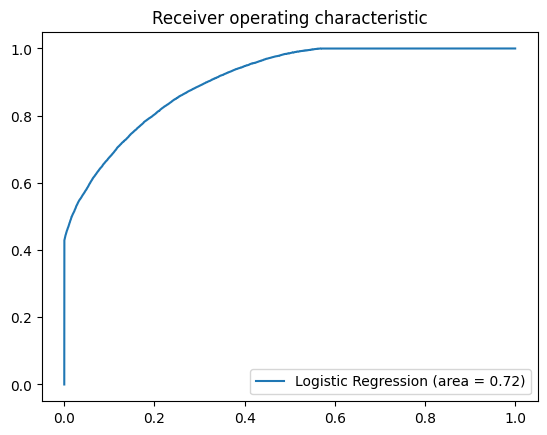

In [ ]:
logit_roc_auc=roc_auc_score(y_test,logreg.predict(X_test))
fpr,tpr,thresholds=roc_curve(y_test,logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr,tpr,label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic')
plt.show()

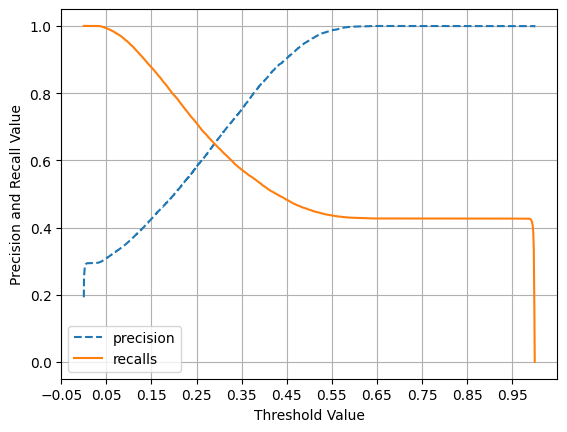

In [ ]:
def precission_recall_curve_plot(y_test,pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test,pred_proba_c1)

    threshold_boundary = thresholds.shape[0]
    #plot precision
    plt.plot(thresholds,precisions[0:threshold_boundary],linestyle='--',label='precision')
    #plot recall
    plt.plot(thresholds,recalls[0:threshold_boundary],label='recalls')

    start,end=plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))

    plt.xlabel('Threshold Value')
    plt.ylabel('Precision and Recall Value')
    plt.legend()
    plt.grid()
    plt.show()

precission_recall_curve_plot(y_test,logreg.predict_proba(X_test)[:,1])

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_test,logreg.predict_proba(X_test)[:,1])
matching_threshold = thresholds[np.argmax(precisions == recalls)]

In [ ]:
val = 0.25
for i in range(0, 6, 1):
    print( val+(i*0.5))
    y_test_pred_labels = (logreg.predict_proba(X_test)[:, 1] >= val+(i*0.5)).astype(int)
    y_train_pred_labels = (logreg.predict_proba(X_train)[:, 1] >= val+(i*0.5)).astype(int)
    print(classification_report(y_train_pred_labels,logreg.predict(X_train)))
    print(classification_report(y_test_pred_labels,y_pred))

0.25
              precision    recall  f1-score   support

           0       0.84      1.00      0.91    201268
           1       1.00      0.39      0.56     62956

    accuracy                           0.85    264224
   macro avg       0.92      0.69      0.73    264224
weighted avg       0.88      0.85      0.83    264224

              precision    recall  f1-score   support

           0       0.84      1.00      0.91     86624
           1       1.00      0.39      0.56     26616

    accuracy                           0.86    113240
   macro avg       0.92      0.69      0.74    113240
weighted avg       0.88      0.86      0.83    113240

0.75
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    242308
           1       0.90      1.00      0.95     21916

    accuracy                           0.99    264224
   macro avg       0.95      1.00      0.97    264224
weighted avg       0.99      0.99      0.99    264224

         

In [ ]:
y_test_pred_labels = (logreg.predict_proba(X_test)[:, 1] >= 0.75).astype(int)
y_train_pred_labels = (logreg.predict_proba(X_train)[:, 1] >= 0.75).astype(int)
print(classification_report(y_train_pred_labels,logreg.predict(X_train)))
print(classification_report(y_test_pred_labels,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    242308
           1       0.90      1.00      0.95     21916

    accuracy                           0.99    264224
   macro avg       0.95      1.00      0.97    264224
weighted avg       0.99      0.99      0.99    264224

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    103949
           1       0.90      1.00      0.95      9291

    accuracy                           0.99    113240
   macro avg       0.95      1.00      0.97    113240
weighted avg       0.99      0.99      0.99    113240



## How can we make sure that our model can detect real defaulters and there are less false positives?

- **Adjusting the decision threshold**: Similar to what we have done above to get a high recall rate, moving the threshold closer to "Fully Paid" will catch more good borrowers but also increase the risk of bad loans. This is a risk-reward trade-off, and the optimal point depends on the  risk tolerance and business goals.
- **Cost-benefit analysis**: Analyze the financial impact of both false positives and negatives. Quantifying the costs can help us make an informed decision about the optimal threshold.
- **Model refinement**: Explore feature engineering or model tuning techniques to improve the model's ability to distinguish good and bad borrowers.

## Since NPA (non-performing asset) is a real problem in this industry, it’s important we play safe and shouldn’t disburse loans to anyone. (10 Points)

- **Adjusting the decision threshold**:  A good way to find potential NPAs is to have models with high recall rate, moving the threshold closer to "Charged Off" will catch more defaulters but also increase the risk of losing potential opportunites. This is a risk-reward trade-off, and the optimal point depends on the  risk tolerance and business goals.
- **Segmenting borrowers**: Implementing risk-based pricing and lending terms based on borrower profiles. This helps target higher interest rates to riskier borrowers, offsetting potential losses.
- **Monitoring and early intervention**: Continuously monitor loan performance and proactively engage with borrowers showing signs of delinquency. Early intervention can prevent defaults and minimize losses.
- **Stress testing**: Regularly test your models and portfolio against various economic scenarios to assess risk and identify potential vulnerabilities.

**What percentage of customers have fully paid their Loan Amount?**
- 80.38% of customers paid fully.

**Comment about the correlation between Loan Amount and Installment features.**
- Correlation between these columns is 0.97. We removed them in the data preprocessing as one explains the other well.

**The majority of people have home ownership as Mortgage.**


**People with grades ‘A’ are more likely to fully pay their loan. (T/F)**
- True

**Name the top 2 afforded job titles.**
- Afforded means to be able to bear the cost of
- Senior Systems Administrator have 28 customers with 100% Fully Paid and Federal Bureau of Prisons has 26 customers with 100% Fully paid.

In [ ]:
result_df = dataOG.groupby('emp_title')['loan_status'].value_counts(normalize=True).unstack() * 100
result_df['Total Customers'] = dataOG['emp_title'].value_counts()

result_df = result_df.fillna(0).rename(columns={'charged off': 'Charged Off Percentage'})

In [ ]:
result_df.sort_values(['Fully Paid','Total Customers'], ascending=False)

loan_status,Charged Off,Fully Paid,Total Customers
emp_title,,,
Senior Systems Administrator,0.0,100.0,28
Federal Bureau of Prisons,0.0,100.0,26
Judge,0.0,100.0,24
Stanford University,0.0,100.0,23
Capital One Bank,0.0,100.0,21
...,...,...,...
zevuloni & associates,100.0,0.0,1
zilkha residence,100.0,0.0,1
zms fashion,100.0,0.0,1


**Thinking from a bank's perspective, which metric should our primary focus be on..**
ROC AUC
Precision
Recall
F1 Score

- Banks need all 4 metrics as each metric has it's own upsides and downsides.
- Bank needs to focus on F1 score if they are focusing on a single model for all purposes as the good recall values might miss out business opportunities and good precision values might miss out on potential defaulters.
- Instead, they can look at 2 different models for each purpose as well.
- ROC Curve might not be the right metrics as there is a data imbalance.

**How does the gap in precision and recall affect the bank?**
- If there is a big gap between precision and recall, it means that the model is performing one task well out of 2 tasks.
1. If precision is more, then out of the defaulters the model is picking as defaulters, it has perfomed well. This might not mean that it is picking all the defaulters, it can be a very small subset.
2. If recall is more, then out of all the defaulters present, the model is able to get more right ones. This might mean that the model is getting a lot of false positives as well meaning non-defaulters might get profiled as defautlers and thus losing opportunity.

**Which were the features that heavily affected the outcome?**
Features that affect the outcome the most seems to be
- Pincode
- Annual income
- Revolving Balance
- DTI

**Will the results be affected by geographical location? (Yes/No)**
- Pincode seems to be one of the most important features. So sure, it is affected by geographic location but we do not know what is the reason behind it. This can be that default rates are higher in low income neighbourhoods. It can be data leakage in some way as well.
- In general, personal loan consumption is higher in urban areas than rural, so it is very likely that results might vary.  

# Actionables and Recommendations
- Pincode demography assessment: Find out why certain pincodes have high default rates. There is still potential in the pincodes with high default. So if we do a root-cause analysis and a qualitative analysis of the demography present, we can identify why certain people are a credit risk and why some are not.

- Income Verification and Risk Assessment: It is clear from the model that annual income is important, so we need integrate income verification services to validate income claims and adjust risk scores accordingly.

- Income based pricing - Link annual income to loan interest rates and terms, offering lower rates for borrowers with higher income and greater debt repayment capacity.

- Alternative Lending Products: We can develop income-based loan products for specific job titles/purposes like salaried professionals or self-employed individuals with varying income patterns.

- Revolving Line Utilization Risk: Analyze revolving balance and utilization rate to assess borrowers' credit management behaviors and adjust risk scores accordingly.

- Financial Stability and Overdependence on Credit: Analyze the number of open credit accounts and utilization rates to understand borrowers' financial stability and potential dependence on credit, informing risk assessment.

- Early Intervention and Financial Education: Identify borrowers with high DTI or revolving line utilization for early intervention with financial education or debt management assistance programs.